## Import 

In [ ]:
!nvidia-smi

Thu Dec 29 02:32:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from PIL import Image
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import torch, torchvision
import torchvision.transforms as T
print(torch.__version__, torch.cuda.is_available())
torch.set_grad_enabled(False);

1.13.0+cu116 True


In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


In [ ]:
# Clone repo 
%cd /content/
!git clone https://github.com/woctezuma/detr.git
%cd detr/
!git checkout finetune

## Download

### DETR-Res50 0Head

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save 
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

### PASVOC12

```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [ ]:
%cd /content
!curl -L "https://public.roboflow.com/ds/HTOnUg8QNl?key=hndrw5iQpo" > roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip

In [ ]:
!mkdir /content/data
!mkdir /content/data/custom
!mkdir -p /content/data/custom/annotations/
!mv /content/train/_annotations.coco.json /content/data/custom/annotations/custom_train.json
!mv /content/val/_annotations.coco.json /content/data/custom/annotations/custom_val.json

!mkdir -p /content/data/custom/train2017/
!mv /content/train/*.jpg /content/data/custom/train2017/
!mkdir -p /content/data/custom/val2017/
!mv /content/val/*.jpg /content/data/custom/val2017/

In [ ]:
# Check dataset for finetuning
dataDir='/content/data/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
# Initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['VOC', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Super-categories: {'none', 'VOC'}


In [ ]:
# Load and display image
catIds = coco.getCatIds(catNms=[['VOC', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']]);
imgIds = coco.getImgIds(catIds=catIds );

In [ ]:
# w/o bb 
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
# w bb 
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

In [ ]:
# Boilerplate variables
first_class_index = 0 
num_classes = 21 
finetuned_classes = ["VOC",'aeroplane', 'bicycle', 'bird', 'boat', 
                       'bottle', 'bus', 'car', 'cat', 'chair', 
                       'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
                       'person', 'pottedplant', 'sheep', 'sofa', 'train', 
                       'tvmonitor']

First class index: 0
Parameter num_classes: 21
Fine-tuned classes: ['VOC', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [ ]:
%cd /content/detr/

!python main.py --dataset_file "custom" \
                --batch_size 8 \
                --coco_path "/content/data/custom/" \
                --output_dir "outputs" \
                --resume "/content/detr/outputs/checkpoint.pth" \
                --num_classes $num_classes \
                --epochs 40

/content/detr
Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=8, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/data/custom/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=40, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=21, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='/content/detr/outputs/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208

## Results

### Tracking Loss 

In [ ]:
%cd /content/detr 

# solid lines: training results 
# dashed lines: validation results
from util.plot_utils import plot_logs
from pathlib import Path

log_directory = [Path('outputs/')]

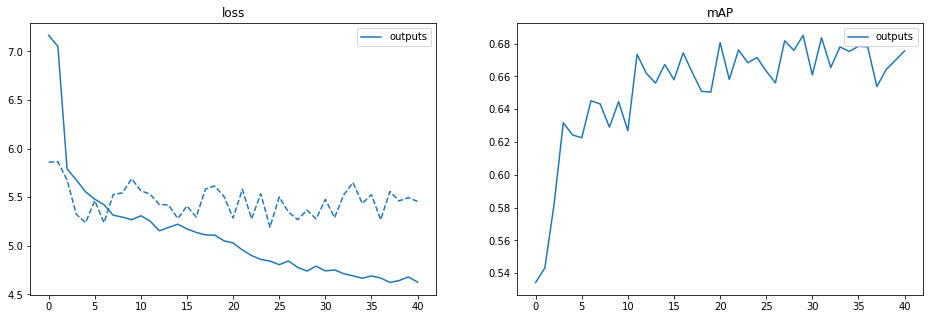

In [ ]:
plot_logs(log_directory,
          ("loss", "mAP"))

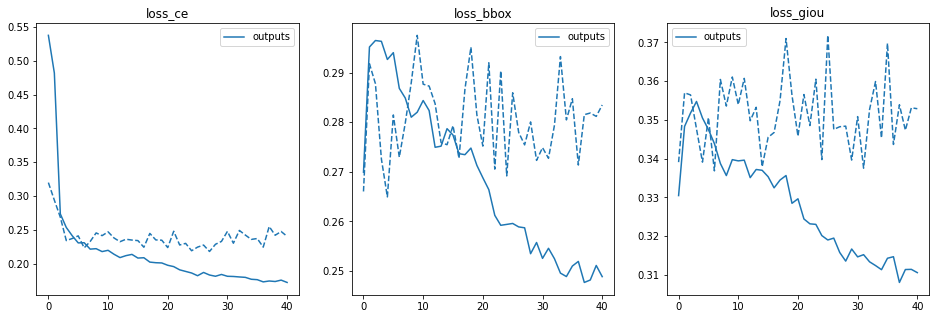

In [ ]:
plot_logs(log_directory,
          ('loss_ce', 'loss_bbox', 'loss_giou',))

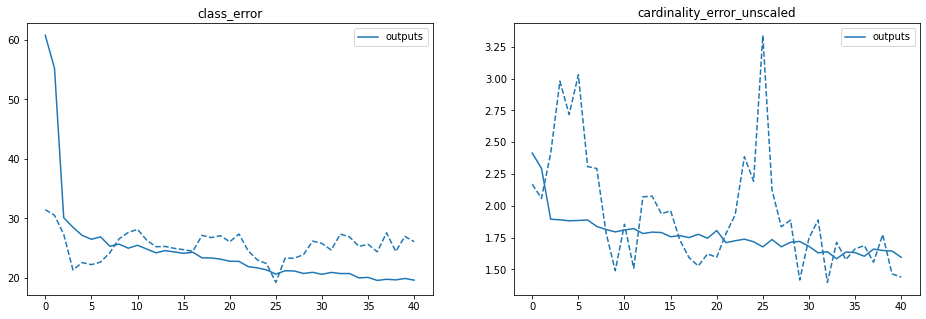

In [ ]:
plot_logs(log_directory,
          ('class_error','cardinality_error_unscaled',))   

### Test 

In [ ]:
# Load the fine-tuned model
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

In [ ]:
# Training image 
from PIL import Image

img_name = '/content/data/custom/train2017/2012_003946_jpg.rf.334300d44f983bf5d521395513a8090d.jpg'
im = Image.open(img_name)

run_worflow(im,model)

In [ ]:
# Validation image 
img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
im = Image.open(img_name)

run_worflow(im, model)